# Trajectory Recommendation using POI Ranking and Active Learning

## 1. Overview

1. Rank POIs using rankSVM
1. Recommend a set of POIs given (start, end, length)

In [34]:
% matplotlib inline

import os, re, sys, time, pickle, tempfile
import math, random, itertools, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from joblib import Parallel, delayed

In [35]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [36]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [93]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-rank-' + suffix + '.pkl')
fF1data = os.path.join(data_dir, 'F1-rank-' + suffix + '.pkl')
fAccdata = os.path.join(data_dir, 'Acc-rank-' + suffix + '.pkl')

In [38]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [39]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [40]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [41]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [42]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 2.2 Construct Travelling Sequences

In [43]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [44]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,userID,seqLen
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


In [45]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [46]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    return poi_info.copy()

## 2.3 Train vs. Query vs. Test Data

Split sequences into training set and test data.

In [47]:
query_percent = 0.5
seqid_set_train0 = []
seqid_set_query0 = []
seqid_set_test0 = []
query_id_dict = dict()  # (start, end, length) --> qid

Remove duplicate trajectories, i.e. same trajectory for different users.

In [48]:
seq_stats = seq_stats[seq_stats['seqLen'] > 2]
seq_stats = seq_stats[seq_stats['seqLen'] < 10]
seqid_set_ = seq_stats.index.tolist()
seq_dict = dict()
for seqid in seqid_set_:
    seq = extract_seq(seqid, seq_all)
    key = str(seq)
    if key in seq_dict: seq_dict[key].append(seqid)
    else: seq_dict[key] = [seqid]

In [49]:
len(seqid_set_)

333

In [50]:
seqid_set_exp = [seq_dict[x][0] for x in sorted(seq_dict.keys())]

In [51]:
len(seqid_set_exp)

290

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [52]:
seqs_exp = [extract_seq(seqid, seq_all) for seqid in seqid_set_exp]
keys = [(seq[0], seq[-1], len(seq)) for seq in seqs_exp]
cnt = 0
for key in keys:
    if key not in query_id_dict:   # (start, end, length) --> qid
        query_id_dict[key] = cnt
        cnt += 1

Random split trajectories for training, querying and testing.  
Make sure all POIs in test set are covered in trajectories for training and query.

In [53]:
ntrain = 1
nquery = int(query_percent * len(seqid_set_exp))

In [54]:
if os.path.exists(fseqpart):
    (seqid_set_train0, seqid_set_query0, seqid_set_test0) = pickle.load(open(fseqpart, 'rb'))
else:
    while True:
        np.random.shuffle(seqid_set_exp)
        
        seqid_set_train0 = sorted(list(seqid_set_exp[:ntrain]))
        seqid_set_query0 = sorted(list(seqid_set_exp[ntrain:ntrain+nquery]))
        seqid_set_test0 = sorted(list(seqid_set_exp[ntrain+nquery:]))
        poi_train = seq_all[seq_all['seqID'].isin(seqid_set_train0)]['poiID'].unique().tolist()
        poi_query = seq_all[seq_all['seqID'].isin(seqid_set_query0)]['poiID'].unique().tolist()
        poi_test  = seq_all[seq_all['seqID'].isin(seqid_set_test0)]['poiID'].unique().tolist()
        train_query_set = set(poi_train) | set(poi_query)
        if len(set(poi_test)) == len(train_query_set & set(poi_test)):
            pickle.dump((seqid_set_train0, seqid_set_query0, seqid_set_test0), open(fseqpart, 'wb'))
            break

In [55]:
print('#seq in total:', len(seqid_set_exp))
print('#seq for training:', ntrain, seqid_set_train0)
print('#seq for querying:', nquery)
print('#seq for testing:', len(seqid_set_exp)-ntrain-nquery)
print('#query tuple:', len(query_id_dict))

#seq in total: 290
#seq for training: 1 [5022]
#seq for querying: 145
#seq for testing: 144
#query tuple: 230


### Features

POI Features used for ranking:
1. `popularity`: POI popularity
2. `avgDuration`: average POI visit duration
3. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
4. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
5. `distStart`: distance (haversine formula) from `startPOI`
6. `distEnd`: distance from `endPOI`
7. `seqLen`: trajectory length (copy from query)
8. `diffPopStart`: difference in POI popularity from `startPOI`
9. `diffPopEnd`: difference in POI popularity from `endPOI`
10. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
11. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`

Features aggregated from a number of trajectories:
1. Compute POI `popularity` and average visit `duration` using all trajectories from training and querying set,
1. Use the same features that computed above for the test set, except the distance based features.

~~Treat POI popularity and POI average visit duration as the properties of POI, so use all trajectories to compute these properties, do NOT just use trajectories in training set to compute these properties (otherwise, for training from just 1 trajectories, these properties of many POI are just 0, which leads to the POI ranking meaningless).~~

In [56]:
poi_info_tq = calc_poi_info(seqid_set_train0 + seqid_set_query0, seq_all, poi_all)
print(poi_info_tq.shape)

(26, 5)


Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [57]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

### Training Data

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$.
1. for each `query`, the label of all absence POIs from trajectories of that `query` in training set got a label 0.

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [58]:
def gen_train_df(seqid_set, seq_all, poi_info, query_id_dict):
    columns = ['poiID', 'label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', \
               'distStart', 'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    seqid_set = sorted(set(seqid_set))
    train_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set]
    for seq in train_seqs:
        assert(len(seq) > 2)
    
    qid_set = sorted(set([query_id_dict[(seq[0], seq[-1], len(seq))] for seq in train_seqs]))
    poi_set = sorted(set(poi_info.index.tolist()))
    qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    
    df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    for i in range(df_.index.shape[0]):
        qid = qid_poi_pair[i][0]
        poi = qid_poi_pair[i][1]
        (p0, pN, seqLen) = query_id_rdict[qid]
        lon0 = poi_info.loc[p0, 'poiLon']; lat0 = poi_info.loc[p0, 'poiLat']
        lonN = poi_info.loc[pN, 'poiLon']; latN = poi_info.loc[pN, 'poiLat']
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; cat = poi_info.loc[poi, 'poiTheme']
        duration = poi_info.loc[poi, 'avgDuration(sec)']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi
        df_.loc[idx, 'queryID'] = qid
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'avgDuration(sec)'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiTheme'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiTheme'] else -1
        df_.loc[idx, 'distStart'] = 0 if poi == p0 else calc_dist(lon, lat, lon0, lat0)
        df_.loc[idx, 'distEnd']   = 0 if poi == pN else calc_dist(lon, lat, lonN, latN)
        df_.loc[idx, 'seqLen'] = seqLen
        df_.loc[idx, 'diffPopStart'] = 0 if poi == p0 else pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = 0 if poi == pN else pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffDurationStart'] = 0 if poi == p0 else duration - poi_info.loc[p0, 'avgDuration(sec)']
        df_.loc[idx, 'diffDurationEnd']   = 0 if poi == pN else duration - poi_info.loc[pN, 'avgDuration(sec)']
    
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    for seq in train_seqs:
        qid = query_id_dict[(seq[0], seq[-1], len(seq))]
        for poi in seq[1:-1]:  # do NOT count if the POI is startPOI/endPOI
            df_.loc[(qid, poi), 'label'] += 1
    
    df_.reset_index(inplace=True)
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

In [59]:
#train_df_ = gen_train_df(seqid_set_train0 + seqid_set_query0[:19], seq_all, poi_info_tq, query_id_dict)

In [60]:
#seqs_ = [extract_seq(seqid, seq_all) for seqid in seqid_set_train0 + seqid_set_query0[:19]]
#print(seqs_)
#train_df_[train_df_['label'] > 0]

In [61]:
#pois_tr = train_df_['poiID'].unique().tolist()
#qids_tr = train_df_['queryID'].unique().tolist()
#print('#POI:', len(pois_tr), '\n#Query stuple (start, end, length):', len(qids_tr))
#print('POI:', pois_tr)
#print('QID:', qids_tr)

In [62]:
#train_df_.to_csv('train_sample_dataframe.csv', index=False)

### Test Data

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [63]:
def gen_test_df(startPOI, endPOI, nPOI, poi_info, query_id_dict):
    columns = ['poiID', 'label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', \
               'distStart', 'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    key = (p0, pN, seqLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    
    poi_set = sorted(set(poi_info.index.tolist()))
    df_ = pd.DataFrame(data=np.zeros((len(poi_set), len(columns)), dtype= np.float), columns=columns)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    lon0 = poi_info.loc[p0, 'poiLon']; lat0 = poi_info.loc[p0, 'poiLat']
    lonN = poi_info.loc[pN, 'poiLon']; latN = poi_info.loc[pN, 'poiLat']
    for i in range(df_.index.shape[0]):
        poi = poi_set[i]
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; cat = poi_info.loc[poi, 'poiTheme']
        duration = poi_info.loc[poi, 'avgDuration(sec)']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi 
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'avgDuration(sec)'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiTheme'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiTheme'] else -1
        df_.loc[idx, 'distStart'] = 0 if poi == p0 else calc_dist(lon, lat, lon0, lat0)
        df_.loc[idx, 'distEnd']   = 0 if poi == pN else calc_dist(lon, lat, lonN, latN)
        df_.loc[idx, 'seqLen'] = seqLen
        df_.loc[idx, 'diffPopStart'] = 0 if poi == p0 else pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = 0 if poi == pN else pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffDurationStart'] = 0 if poi == p0 else duration - poi_info.loc[p0, 'avgDuration(sec)']
        df_.loc[idx, 'diffDurationEnd']   = 0 if poi == pN else duration - poi_info.loc[pN, 'avgDuration(sec)']
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

In [64]:
#seq_ = extract_seq(seqid_set_test0[10], seq_all)
#test_df_ = gen_test_df(seq_[0], seq_[-1], len(seq_), poi_info_tq, query_id_dict)

In [65]:
#print(seq_)
#test_df_

In [66]:
#pois_te = test_df_['poiID'].unique().tolist()
#qids_te = test_df_['queryID'].unique().tolist()
#print('#POI:', len(pois_te), '\n#Query stuple (start, end, length):', len(qids_te))
#print('POI:', pois_te)
#print('QID:', qids_te)

In [67]:
#test_df_.to_csv('test_sample_dataframe.csv', index=False)

Generate a string for a training/test data frame.

In [68]:
def gen_data_str(df_):
    columns = ['label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', 'distStart', \
               'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        for j in range(2, len(columns)):
            slist.append(' ')
            slist.append(str(j-1))
            slist.append(':')
            slist.append(str(df_.loc[idx, columns[j]]))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

## 2.4 Ranking POIs using POI Popularity

Ranking POIs using POI popularity computed using all trajectories in training and querying set.

In [69]:
def rank_using_popularity(poi_info):
    poi_rank_df = pd.DataFrame(poi_info['popularity'].copy()) # construct a dataframe from a series
    #print(type(poi_rank_df))
    poi_rank_df.rename(columns={'popularity':'rank'}, inplace=True)
    return poi_rank_df

In [70]:
#poi_info_tq['popularity']
#rank_using_popularity(poi_info_tq)

## 2.5 Ranking POIs using rankSVM

RankSVM implementation in libsvm can be downloaded [here (zip file)](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip), please read `README.ranksvm` in the zip file for installation instructions.

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM.

In [71]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=False, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        #if self.fmodel is not None and os.path.exists(self.fmodel):
        #    os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        #os.unlink(ftrain)
        #os.unlink(ftrain_scaled)
        
    
    def predict(self, test_df, poi_list):
        """
        Row `i` in DataFrame `test_df` corresponds to the features of POI `poi_list[i]`
        """
        assert(test_df.shape[0] == len(poi_list))
        
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
        
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = poi_list
        poi_rank_df.set_index('poiID', inplace=True)
        
        # remove test file and prediction file
        #os.unlink(ftest)
        #os.unlink(ftest_scaled)
        #os.unlink(fpredict)
        
        return poi_rank_df

# 3. Recommend Trajectory

In [72]:
def enum_seq(poi_list, startPOI, endPOI, nPOI):
    """
    Enumerate all possible subset of poi_list without startPOI and endPOI,
    The size of subset is nPOI-2
    """
    assert(nPOI > 2)
    assert(nPOI < len(poi_list))
    tuples = itertools.combinations([p for p in poi_list if p not in {startPOI, endPOI}], nPOI-2)
    return [[startPOI] + list(x) + [endPOI] for x in tuples]

In [73]:
def calc_F1score(seq_act, seq_rec, includeStartEnd=True):
    assert(len(seq_act) > 2)
    assert(len(seq_rec) > 2)

    act_set = set(seq_act)
    rec_set = set(seq_rec)
    intersect = act_set & rec_set
    
    recall    = len(intersect) / len(act_set) if includeStartEnd else (len(intersect)-2) / (len(act_set)-2)
    precision = len(intersect) / len(rec_set) if includeStartEnd else (len(intersect)-2) / (len(rec_set)-2)
    F1score   = 0 if abs(precision + recall) < 1e-6 else 2. * precision * recall / (precision + recall)
  
    return F1score

In [74]:
def do_evaluate(seq, poi_info, poi_rank_df, debug=False):
    pois = poi_rank_df.index.tolist()
    np.random.shuffle(pois) # tie breaking
    pois = np.array(pois)
    ranks = poi_rank_df.loc[pois, 'rank'].get_values()
    ranked_poi = pois[ranks.argsort()][::-1]  # highest rank --> lowest rank 
    ranked_poi = list(ranked_poi)

    # recommend the top ranked POIs
    poi_rec = [p for p in ranked_poi if p not in {seq[0], seq[-1]}][:len(seq)-2]
    seq_rec = [seq[0]] + poi_rec + [seq[-1]]
    F1  = calc_F1score(seq, seq_rec)
    F1_ = calc_F1score(seq, seq_rec, includeStartEnd=False)
    
    if debug:
        print('POI ranking:', ranked_poi)
        #print('%.2f: %-20s -> %s' % (F1, str(seq), str(seq_rec)))
    return F1, F1_

In [75]:
def evaluate_parallel(seqid_set_test, seq_all, poi_info, query_id_dict, ranksvm, debug=False):
    assert(isinstance(debug, bool))
    
    test_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_test]
    test_df_list = Parallel(n_jobs=-2)\
                           (delayed(gen_test_df)(seq[0], seq[-1], len(seq), poi_info, query_id_dict)\
                            for seq in test_seqs) 
    
    rank_df_list = [ranksvm.predict(test_df_list[i], poi_info.index) for i in range(len(test_df_list))]
    
    assert(len(test_seqs) == len(rank_df_list))
    #F1scores = [do_evaluate(test_seqs[i], poi_info, rank_df_list[i], debug) for i in range(len(rank_df_list))]
    
    F1scores  = []
    F1scores_ = []
    for i in range(len(test_seqs)):
        #poi_rank_df = ranksvm.predict(test_df_list[i], poi_info.index)
        F1, F1_ = do_evaluate(test_seqs[i], poi_info, rank_df_list[i], debug)
        F1scores.append(F1)
        F1scores_.append(F1_)
    return F1scores, F1scores_

In [76]:
def evaluate_poprank(seqid_set_test, seq_all, poi_info, query_id_dict, debug=False):
    assert(isinstance(debug, bool))
    
    test_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_test]
    poi_rank_df = rank_using_popularity(poi_info)  # the same ranking for all testing cases
    #F1scores = [do_evaluate(test_seqs[i], poi_info, poi_rank_df, debug) for i in range(len(test_seqs))]
    
    F1scores  = []
    F1scores_ = []
    for i in range(len(test_seqs)):
        #poi_rank_df = rank_using_popularity(poi_info)
        F1, F1_ = do_evaluate(test_seqs[i], poi_info, poi_rank_df, debug)
        F1scores.append(F1)
        F1scores_.append(F1_)
    return F1scores, F1scores_

In [77]:
def evaluate_poprank2(seqid_set_test, seq_all, poi_info, query_id_dict, debug=False):
    assert(isinstance(debug, bool))
    
    test_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_test]
    poi_rank_df = rank_using_popularity(poi_info)  # the same ranking for all testing cases
    
    ncorrect = 0
    ntotal = 0
    for i in range(len(test_seqs)):
        seq = test_seqs[i]
        pois = poi_rank_df.index.tolist()
        np.random.shuffle(pois) # tie breaking
        pois = np.array(pois)
        ranks = poi_rank_df.loc[pois, 'rank'].get_values()
        ranked_poi = pois[ranks.argsort()][::-1]  # highest rank --> lowest rank 
        ranked_poi = list(ranked_poi)

        # recommend the top ranked POIs
        poi_rec = [p for p in ranked_poi if p not in {seq[0], seq[-1]}][:len(seq)-2]
        
        ncorrect += len(set(seq[1:-1]) & set(poi_rec))
        ntotal += len(set(seq[1:-1]))
    return ncorrect / ntotal

The problem of the above F1 is
- sensitive to the distribution of trajectory length, i.e. number of POIs in a trajectory, short trajectories are more likely to get a high score, even if just guess randomly.
- think about the extreme cases: suppose our algorithm just predict by guessing and we have $20$ POIs in total.
  - all trajectories in test set are of length 3, the expected F1: 
    $\text{(probability to choose the correct POI)} \times \text{(F1 when the middle POI is correct)} + 
    \text{(probability to choose the incorrect POI)} \times \text{(F1 when the middle POI is not correct)} = 
    \frac{1}{20-2} \times 1 + \frac{20-3}{20-2} \times \frac{2}{3} = \frac{37}{54} \approx 0.69$
  - similarly, when all trajectories in test set are of length 5, the expected F1 is $0.5$, but our predictive power doesn't change between the two cases!
  - the expected F1 of random guessing can be computed use the following function.

In [78]:
from scipy.misc import comb
from math import factorial
def rand_guess(npoi, length):
    assert(length <= npoi)
    if length == npoi: return 1
    N = npoi - 2
    m = length - 2 # number of correct POIs
    k = m
    expected_F1 = 0
    while k >= 0:
        F1 = (k + 2) / length
        prob = comb(m, k) * comb(N-m, m-k) / comb(N, m)
        expected_F1 += prob * F1
        k -= 1
    return expected_F1

In [79]:
rand_guess(20, 5)

0.5

Use a new evaluation metric that can reflect our predictive power directly, i.e. rate of correctly predicted POIs: $\frac{\text{number_of_POIs_correctly_predicted}}{\text{total_number_of_POIs_predicted}}$.

In [80]:
def evaluate_newmetric(seqid_set_test, seq_all, poi_info, query_id_dict, ranksvm, debug=False):
    assert(isinstance(debug, bool))
    
    test_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_test]
    test_df_list = Parallel(n_jobs=-2)\
                           (delayed(gen_test_df)(seq[0], seq[-1], len(seq), poi_info, query_id_dict)\
                            for seq in test_seqs) 
    
    rank_df_list = [ranksvm.predict(test_df_list[i], poi_info.index) for i in range(len(test_df_list))]
    
    assert(len(test_seqs) == len(rank_df_list))
    
    ncorrect = 0
    ntotal = 0
    for i in range(len(test_seqs)):
        seq = test_seqs[i]
        poi_rank_df = rank_df_list[i]
        pois = poi_rank_df.index.tolist()
        np.random.shuffle(pois) # tie breaking
        pois = np.array(pois)
        ranks = poi_rank_df.loc[pois, 'rank'].get_values()
        ranked_poi = pois[ranks.argsort()][::-1]  # highest rank --> lowest rank 
        ranked_poi = list(ranked_poi)

        # recommend the top ranked POIs
        poi_rec = [p for p in ranked_poi if p not in {seq[0], seq[-1]}][:len(seq)-2]
        
        ncorrect += len(set(seq[1:-1]) & set(poi_rec))
        ntotal += len(set(seq[1:-1]))
    return ncorrect / ntotal

Sanity check.

In [71]:
train_set_ = seqid_set_train0 + seqid_set_query0[:19]
train_df_ = gen_train_df(train_set_, seq_all, poi_info_tq, query_id_dict)
ranksvm_ = RankSVM(ranksvm_dir, debug=True)
C_ = 1000
ranksvm_.train(train_df_, C_)

model file: /tmp/tmpo8u5epad
feature scaling parameter file: /tmp/tmp72op53qd
cost: 1000
train data file: /tmp/tmpn8vv_t76
feature scaled train data file: /tmp/tmpjhwsjdyl
Training finished.
iter  1 act 4.882e+05 pre 4.781e+05 delta 2.607e-01 f 8.600e+05 |g| 3.776e+06 CG   2
cg reaches trust region boundary
iter  2 act 3.580e+04 pre 3.111e+04 delta 3.400e-01 f 3.718e+05 |g| 3.641e+05 CG   4
cg reaches trust region boundary
iter  3 act 2.356e+04 pre 2.241e+04 delta 3.922e-01 f 3.360e+05 |g| 2.281e+05 CG   3
cg reaches trust region boundary
iter  4 act 2.770e+04 pre 2.636e+04 delta 6.822e-01 f 3.125e+05 |g| 2.178e+05 CG   4
cg reaches trust region boundary
iter  5 act 3.111e+04 pre 3.017e+04 delta 1.534e+00 f 2.848e+05 |g| 1.340e+05 CG   3
cg reaches trust region boundary
iter  6 act 3.787e+04 pre 3.220e+04 delta 1.891e+00 f 2.537e+05 |g| 9.482e+04 CG   3
cg reaches trust region boundary
iter  7 act 3.871e+04 pre 3.405e+04 delta 2.867e+00 f 2.158e+05 |g| 2.625e+05 CG   6
cg reaches trust

In [97]:
seq_ = extract_seq(seqid_set_test0[101], seq_all)
print(seq_)
test_df_ = gen_test_df(seq_[0], seq_[-1], len(seq_), poi_info_tq, query_id_dict)
poi_rank_ = ranksvm_.predict(test_df_, poi_info_tq.index)

[29, 6, 22, 28, 21]
test data file: /tmp/tmp11inmoty
feature scaled test data file: /tmp/tmpfw2em38m
predict result file: /tmp/tmpqnbeseky
Predict result: Pairwise Accuracy = 47.6923%    MeanNDCG (LETOR) = 0.605606


In [98]:
poi_rank_.reset_index(inplace=True)
poi_rank_.rename(columns={'rank':'rank_score'}, inplace=True)
argsort_ = poi_rank_['rank_score'].get_values().argsort()[::-1]
poi_rank_.loc[argsort_, 'rank'] = np.arange(1, poi_rank_.shape[0]+1)
poi_rank_

,poiID,rank_score,rank
0,1,-1.092750,12
1,2,-6.800080,22
2,3,-0.480049,11
3,4,-1.364940,14
4,6,0.071244,7
5,7,0.342946,6
6,8,-0.259121,10
7,10,-4.202070,20
8,11,-1.123180,13
9,13,-3.377970,19


In [99]:
poi_rank_.to_csv('rank_sample3.csv', index=False)

In [72]:
F1scores1, F1scores1_ = evaluate_parallel(train_set_, seq_all, poi_info_tq, query_id_dict, ranksvm_)

test data file: /tmp/tmplm4ln3dv
feature scaled test data file: /tmp/tmpunw2plby
predict result file: /tmp/tmpfzgsvx7j
Predict result: Pairwise Accuracy = 42.7692%    MeanNDCG (LETOR) = 0.557763
test data file: /tmp/tmpwcbhrb8h
feature scaled test data file: /tmp/tmp3pckfew8
predict result file: /tmp/tmpuw2vg1dn
Predict result: Pairwise Accuracy = 36%         MeanNDCG (LETOR) = 0.50588
test data file: /tmp/tmp1d826hkh
feature scaled test data file: /tmp/tmp9k22bpxp
predict result file: /tmp/tmpwcyaw_if
Predict result: Pairwise Accuracy = 39.6923%    MeanNDCG (LETOR) = 0.480194
test data file: /tmp/tmpipfhxaoz
feature scaled test data file: /tmp/tmpa219t40g
predict result file: /tmp/tmpnue1e9ox
Predict result: Pairwise Accuracy = 37.5385%    MeanNDCG (LETOR) = 0.432999
test data file: /tmp/tmpbt3_gs8b
feature scaled test data file: /tmp/tmp8y8pmjix
predict result file: /tmp/tmpkky59zob
Predict result: Pairwise Accuracy = 38.1538%    MeanNDCG (LETOR) = 0.51967
test data file: /tmp/tmpero

In [ ]:
F1scores2, F1scores2_ = evaluate_parallel(seqid_set_test0, seq_all, poi_info_tq, query_id_dict, ranksvm_)

## 3.1 Leave-one-out

Compare the performance with IJCAI paper use the same leave-one-out evaluation strategy.

In [44]:
def leave1out(seqid_set_all, seq_all, seq_info, query_id_dict):
    F1scores_train = []
    F1scores_test  = []
    
    for i in range(len(seqid_set_all)):
        seqid_set_train = seqid_set_all[:i] + seqid_set_all[i+1:]
        seqid_set_test = [seqid_set_all[i]]
        train_df = gen_train_df(seqid_set_train, seq_all, poi_info, query_id_dict)
        
        # training rankSVM
        #C = 10
        #C = 30
        #C = 100
        #C = 300
        C = 1000
        ranksvm = RankSVM(ranksvm_dir)
        ranksvm.train(train_df, C)
        #poi_rank_df = ranksvm.predict(train_df)
        
        # compute training accuracy
        F1scores = evaluate_parallel(seqid_set_train, seq_all, poi_info, query_id_dict, ranksvm)
        F1scores_train.append(F1scores)
        
        # compute testing accuracy
        F1scores = evaluate_parallel(seqid_set_test, seq_all, poi_info, query_id_dict, ranksvm)
        F1scores_test.append(F1scores)
        
    return F1scores_train, F1scores_test

In [45]:
#F1_l1o_train, F1_l1o_test = leave1out(seqid_set_exp, seq_all, seq_info_tq, query_id_dict)

## 3.2 Random Baseline - Passive Learing

Choose a sequence to query uniformly at random, i.e. passive learning.

Rank POIs by their popularities only.

In [81]:
def random_baseline_pop(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_info, query_id_dict):
    np.random.shuffle(seqid_set_query)
    query_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_query]
    F1scores_train  = []
    F1scores_test   = []
    F1scores_train_ = []
    F1scores_test_  = []
    
    cnt = 0
    while len(seqid_set_query) > 0:
        # compute training accuracy
        F1scores, F1scores_ = evaluate_poprank(seqid_set_train, seq_all, poi_info, query_id_dict)
        F1scores_train.append(F1scores)
        F1scores_train_.append(F1scores_)
        print('Iteration %d, train mean F1: %.2f\n' % (cnt, np.mean(F1scores)))
        
        # compute testing accuracy
        F1scores, F1scores_ = evaluate_poprank(seqid_set_test, seq_all, poi_info, query_id_dict)
        F1scores_test.append(F1scores)
        F1scores_test_.append(F1scores_)
        print('Iteration %d, test  mean F1: %.2f\n' % (cnt, np.mean(F1scores)))
        
        # query strategy
        seq_idx = -1 # the last element after random shuffle
        seqid_set_train.append(seqid_set_query[seq_idx])
        print('choose sequence:', query_seqs[seq_idx])
        del seqid_set_query[seq_idx]
        del query_seqs[seq_idx]
        
        cnt += 1
        
    return F1scores_train, F1scores_test, F1scores_train_, F1scores_test_

In [82]:
def random_baseline_pop2(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_info, query_id_dict):
    np.random.shuffle(seqid_set_query)
    query_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_query]
    acc_train = []
    acc_test = []
    
    cnt = 0
    while len(seqid_set_query) > 0:
        # compute training accuracy
        acc1 = evaluate_poprank2(seqid_set_train, seq_all, poi_info, query_id_dict)
        acc_train.append(acc1)
        print('Iteration %d, train accuracy: %.2f\n' % (cnt, acc1))
        
        # compute testing accuracy
        acc2 = evaluate_poprank2(seqid_set_test, seq_all, poi_info, query_id_dict)
        acc_test.append(acc2)
        print('Iteration %d, test  accuracy: %.2f\n' % (cnt, acc2))
        
        # query strategy
        seq_idx = -1 # the last element after random shuffle
        seqid_set_train.append(seqid_set_query[seq_idx])
        print('choose sequence:', query_seqs[seq_idx])
        del seqid_set_query[seq_idx]
        del query_seqs[seq_idx]
        
        cnt += 1
        
    return acc_train, acc_test

Rank POIs by rankSVM trained using a number of POI features.

In [83]:
def random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_info, query_id_dict, useLinear=False):
    np.random.shuffle(seqid_set_query)
    query_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_query]
    F1scores_train  = []
    F1scores_test   = []
    F1scores_train_ = []
    F1scores_test_  = []
    
    
    cnt = 0
    while len(seqid_set_query) > 0:
        # compute features for training
        #poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_train_df(seqid_set_train, seq_all, poi_info, query_id_dict)
        
        # training rankSVM
        #C = 1
        #C = 10
        #C = 30
        #C = 100
        #C = 300
        C = 1000
        #C = 1e6
        ranksvm = RankSVM(ranksvm_dir, useLinear=useLinear)#, debug=True)
        ranksvm.train(train_df, C)
 
        # compute training accuracy
        #F1scores = evaluate(seqid_set_test, seq_all, poi_info, query_id_dict, ranksvm)
        F1scores, F1scores_ = evaluate_parallel(seqid_set_train, seq_all, poi_info, query_id_dict, ranksvm)
        F1scores_train.append(F1scores)
        F1scores_train_.append(F1scores_)
        print('Iteration %d, train mean F1: %.2f\n' % (cnt, np.mean(F1scores)))
        
        # compute testing accuracy
        t0 = time.time()
        #F1scores = evaluate(seqid_set_test, seq_all, poi_info, query_id_dict, ranksvm)
        F1scores, F1scores_ = evaluate_parallel(seqid_set_test, seq_all, poi_info, query_id_dict, ranksvm)
        F1scores_test.append(F1scores)
        F1scores_test_.append(F1scores_)
        print('%d seconds used.' % int(time.time() - t0))
        print('Iteration %d, test  mean F1: %.2f\n' % (cnt, np.mean(F1scores)))
        
        # query strategy
        seq_idx = -1 # the last element after random shuffle
        seqid_set_train.append(seqid_set_query[seq_idx])
        print('choose sequence:', query_seqs[seq_idx])
        del seqid_set_query[seq_idx]
        del query_seqs[seq_idx]
        
        cnt += 1
        
    return F1scores_train, F1scores_test, F1scores_train_, F1scores_test_

In [87]:
def random_baseline2(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_info, query_id_dict, useLinear=False):
    np.random.shuffle(seqid_set_query)
    query_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_query]
    acc_train = []
    acc_test = []
    
    cnt = 0
    while len(seqid_set_query) > 0:
        # compute features for training
        #poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_train_df(seqid_set_train, seq_all, poi_info, query_id_dict)
        
        # training rankSVM
        #C = 1
        #C = 10
        #C = 30
        #C = 100
        #C = 300
        C = 1000
        #C = 1e6
        ranksvm = RankSVM(ranksvm_dir, useLinear=useLinear)#, debug=True)
        ranksvm.train(train_df, C)
 
        # compute training accuracy
        acc1 = evaluate_newmetric(seqid_set_train, seq_all, poi_info, query_id_dict, ranksvm)
        acc_train.append(acc1)
        print('Iteration %d, train accuracy: %.2f\n' % (cnt, acc1))
        
        # compute testing accuracy
        acc2 = evaluate_newmetric(seqid_set_test, seq_all, poi_info, query_id_dict, ranksvm)
        acc_test.append(acc2)
        print('Iteration %d, test  accuracy: %.2f\n' % (cnt, acc2))
        
        # query strategy
        seq_idx = -1 # the last element after random shuffle
        seqid_set_train.append(seqid_set_query[seq_idx])
        print('choose sequence:', query_seqs[seq_idx])
        del seqid_set_query[seq_idx]
        del query_seqs[seq_idx]
        
        cnt += 1
        
    return acc_train, acc_test

# 4. Evaluation

In [85]:
def plot_evaluation_results(F1_train_list, F1_test_list):
    assert(len(F1_train_list) == len(F1_test_list))
    F1_train_mean = [np.mean(x) for x in F1_train_list]
    F1_train_median = [np.median(x) for x in F1_train_list]
    F1_test_mean = [np.mean(x) for x in F1_test_list]
    F1_test_median = [np.median(x) for x in F1_test_list]
    
    plt.figure(figsize=[15, 18])
    plt.subplot(3, 1, 1)
    plt.xlabel('#Query')
    plt.ylabel('Train F1')
    plt.ylim([0.3, 1.05])
    plt.boxplot(F1_train_list)
    plt.plot(np.arange(1, len(F1_train_list)+1), F1_train_mean, color='g', marker='o')
    xticks = [10*x for x in range(math.ceil(len(F1_train_list)/10))]
    plt.xticks(xticks, xticks) # xticks starts from 1
    
    
    plt.subplot(3, 1, 2)
    plt.xlabel('#Query')
    plt.ylabel('Test F1')
    plt.ylim([0.3, 1.05])
    plt.boxplot(F1_test_list)
    plt.plot(np.arange(1, len(F1_test_list)+1), F1_test_mean, color='g', marker='^')
    plt.xticks(xticks, xticks)
    
    plt.subplot(3, 1, 3)
    plt.xlabel('#Query')
    plt.ylabel('F1')
    plt.ylim([0.5, 1.05])
    plt.plot(np.arange(len(F1_train_list)), F1_train_mean, ls='-.', label='Train F1 - Mean')
    plt.plot(np.arange(len(F1_train_list)), F1_train_median, ls='--', label='Train F1 - Median')
    plt.plot(np.arange(len(F1_test_list)), F1_test_mean, ls='-', label='Test F1 - Mean')
    plt.plot(np.arange(len(F1_test_list)), F1_test_median, ls=':', label='Test F1 - Median')
    plt.legend(loc='lower right')

## 4.1 Evaluate Random Baseline Query Strategy

Evaluate passive learning use kernel rankSVM to rank POIs.

In [49]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()

In [50]:
F1_rand_train_s, F1_rand_test_s, F1_rand_train_s_, F1_rand_test_s_ = \
random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_info_tq, query_id_dict)

Iteration 0, train mean F1: 1.00

12 seconds used.
Iteration 0, test  mean F1: 0.58

choose sequence: [7, 22, 28]
Iteration 1, train mean F1: 1.00

12 seconds used.
Iteration 1, test  mean F1: 0.61

choose sequence: [23, 30, 22, 28, 3]
Iteration 2, train mean F1: 0.93

12 seconds used.
Iteration 2, test  mean F1: 0.69

choose sequence: [16, 4, 22, 28]
Iteration 3, train mean F1: 0.87

12 seconds used.
Iteration 3, test  mean F1: 0.68

choose sequence: [22, 8, 3]
Iteration 4, train mean F1: 0.78

13 seconds used.
Iteration 4, test  mean F1: 0.68

choose sequence: [7, 22, 23]
Iteration 5, train mean F1: 0.81

12 seconds used.
Iteration 5, test  mean F1: 0.68

choose sequence: [8, 24, 30]
Iteration 6, train mean F1: 0.88

12 seconds used.
Iteration 6, test  mean F1: 0.67

choose sequence: [28, 23, 22]
Iteration 7, train mean F1: 0.86

12 seconds used.
Iteration 7, test  mean F1: 0.69

choose sequence: [23, 28, 30]
Iteration 8, train mean F1: 0.87

12 seconds used.
Iteration 8, test  mean 

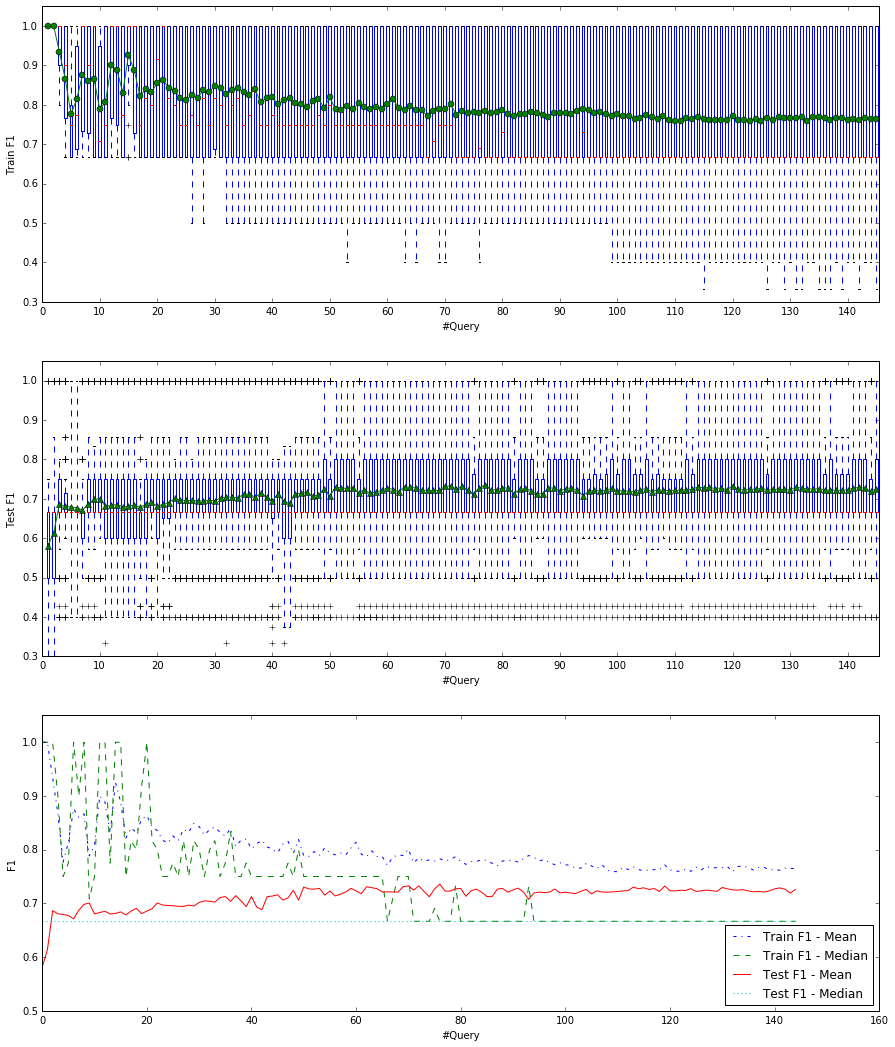

In [51]:
plot_evaluation_results(F1_rand_train_s, F1_rand_test_s)

Evaluate passive learning use linear rankSVM to rank POIs.

In [52]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()

In [53]:
F1_rand_train_l, F1_rand_test_l, F1_rand_train_l_, F1_rand_test_l_ = \
random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_info_tq, query_id_dict, useLinear=True)

Iteration 0, train mean F1: 1.00

12 seconds used.
Iteration 0, test  mean F1: 0.57

choose sequence: [3, 30, 22]
Iteration 1, train mean F1: 1.00

12 seconds used.
Iteration 1, test  mean F1: 0.68

choose sequence: [6, 11, 26]
Iteration 2, train mean F1: 1.00

12 seconds used.
Iteration 2, test  mean F1: 0.66

choose sequence: [16, 22, 29]
Iteration 3, train mean F1: 0.83

12 seconds used.
Iteration 3, test  mean F1: 0.69

choose sequence: [3, 29, 6, 22]
Iteration 4, train mean F1: 0.63

12 seconds used.
Iteration 4, test  mean F1: 0.72

choose sequence: [16, 30, 22, 6]
Iteration 5, train mean F1: 0.71

13 seconds used.
Iteration 5, test  mean F1: 0.73

choose sequence: [11, 23, 3, 30, 7, 16, 4, 1, 2]
Iteration 6, train mean F1: 0.69

12 seconds used.
Iteration 6, test  mean F1: 0.71

choose sequence: [16, 8, 30]
Iteration 7, train mean F1: 0.69

12 seconds used.
Iteration 7, test  mean F1: 0.72

choose sequence: [2, 17, 14]
Iteration 8, train mean F1: 0.72

12 seconds used.
Iteration

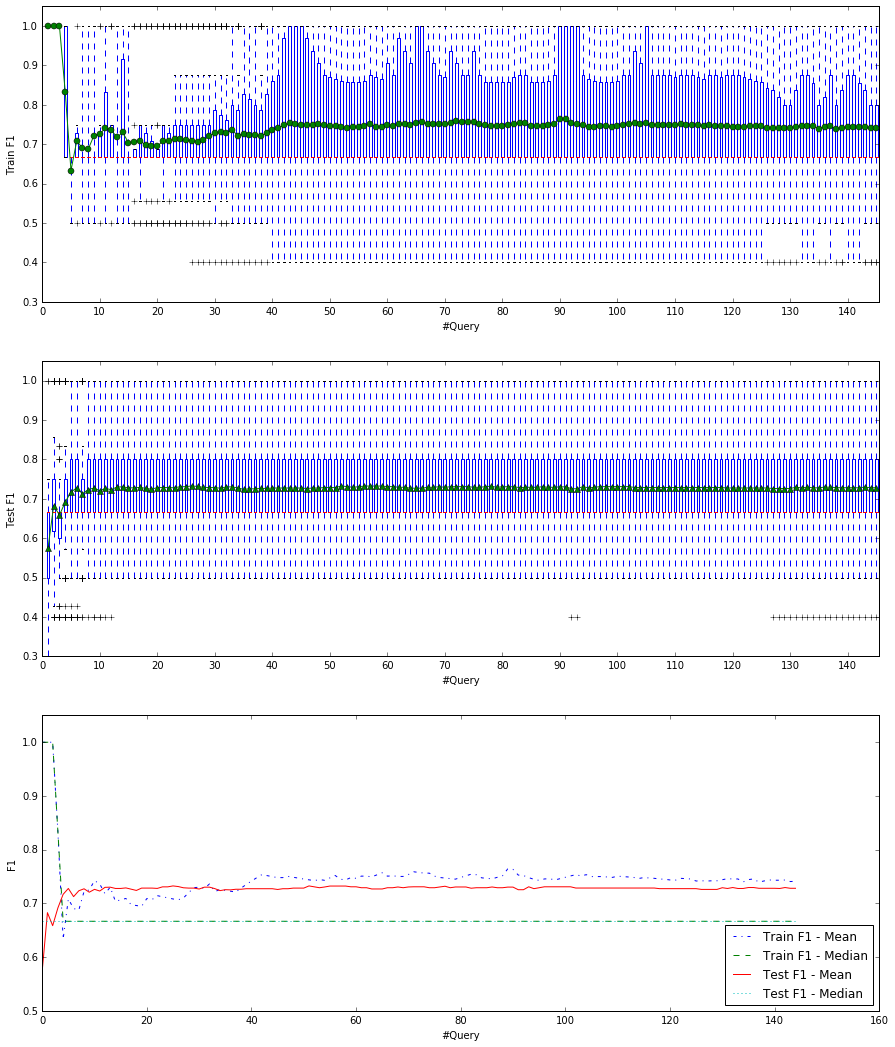

In [58]:
plot_evaluation_results(F1_rand_train_l, F1_rand_test_l)

Evaluate passive learning use POI popularity to rank POIs.

In [54]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()

In [55]:
F1_rand_train_p, F1_rand_test_p, F1_rand_train_p_, F1_rand_test_p_ = \
random_baseline_pop(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_info_tq, query_id_dict)

Iteration 0, train mean F1: 0.67

Iteration 0, test  mean F1: 0.70

choose sequence: [7, 22, 16]
Iteration 1, train mean F1: 0.83

Iteration 1, test  mean F1: 0.70

choose sequence: [23, 22, 28]
Iteration 2, train mean F1: 0.89

Iteration 2, test  mean F1: 0.70

choose sequence: [22, 30, 7, 1, 8, 16, 21]
Iteration 3, train mean F1: 0.85

Iteration 3, test  mean F1: 0.70

choose sequence: [7, 22, 30, 16]
Iteration 4, train mean F1: 0.88

Iteration 4, test  mean F1: 0.70

choose sequence: [7, 23, 28, 30]
Iteration 5, train mean F1: 0.81

Iteration 5, test  mean F1: 0.70

choose sequence: [3, 29, 6, 22]
Iteration 6, train mean F1: 0.80

Iteration 6, test  mean F1: 0.70

choose sequence: [23, 21, 22, 7, 28]
Iteration 7, train mean F1: 0.80

Iteration 7, test  mean F1: 0.70

choose sequence: [21, 6, 23]
Iteration 8, train mean F1: 0.76

Iteration 8, test  mean F1: 0.70

choose sequence: [28, 21, 30]
Iteration 9, train mean F1: 0.75

Iteration 9, test  mean F1: 0.70

choose sequence: [23, 28

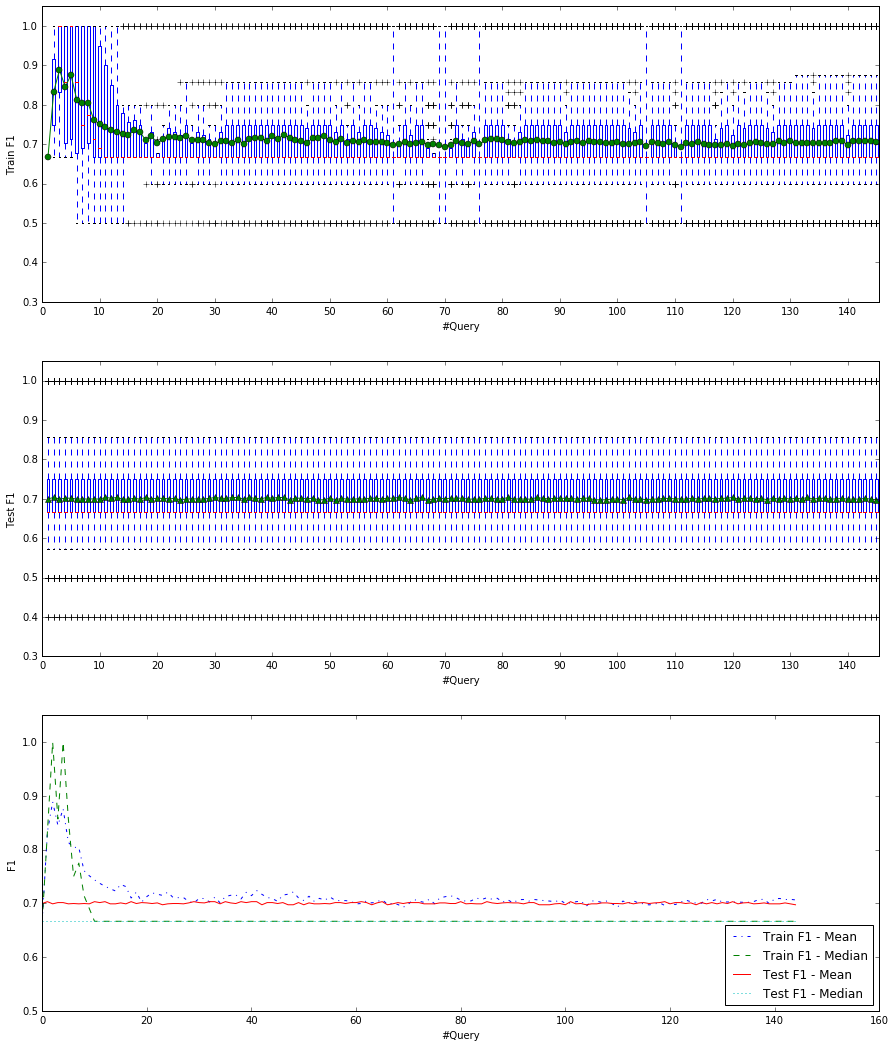

In [59]:
plot_evaluation_results(F1_rand_train_p, F1_rand_test_p)

Dump data to file.

In [60]:
F1_data = (F1_rand_train_s, F1_rand_test_s, F1_rand_train_s_, F1_rand_test_s_,\
           F1_rand_train_l, F1_rand_test_l, F1_rand_train_l_, F1_rand_test_l_,\
           F1_rand_train_p, F1_rand_test_p, F1_rand_train_p_, F1_rand_test_p_)
pickle.dump(F1_data, open(fF1data, 'wb'))

Draw curves of F1 for different settings.

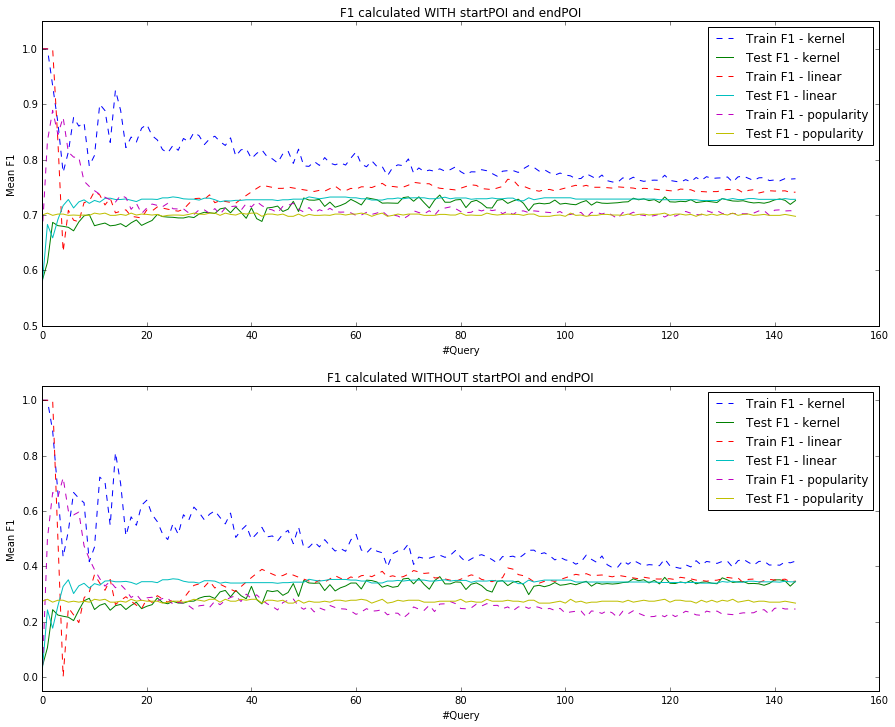

In [64]:
F1_train_mean_s = [np.mean(x) for x in F1_rand_train_s]
F1_train_mean_l = [np.mean(x) for x in F1_rand_train_l]
F1_train_mean_p = [np.mean(x) for x in F1_rand_train_p]

F1_test_mean_s = [np.mean(x) for x in F1_rand_test_s]
F1_test_mean_l = [np.mean(x) for x in F1_rand_test_l]
F1_test_mean_p = [np.mean(x) for x in F1_rand_test_p]

F1_train_mean_s_ = [np.mean(x) for x in F1_rand_train_s_]
F1_train_mean_l_ = [np.mean(x) for x in F1_rand_train_l_]
F1_train_mean_p_ = [np.mean(x) for x in F1_rand_train_p_]

F1_test_mean_s_ = [np.mean(x) for x in F1_rand_test_s_]
F1_test_mean_l_ = [np.mean(x) for x in F1_rand_test_l_]
F1_test_mean_p_ = [np.mean(x) for x in F1_rand_test_p_]

plt.figure(figsize=[15, 12])
plt.subplot(2, 1, 1)
plt.ylim([0.5, 1.05])
plt.xlabel('#Query')
plt.ylabel('Mean F1')
plt.title('F1 calculated WITH startPOI and endPOI')

plt.plot(np.arange(len(F1_train_mean_s)), F1_train_mean_s, ls='--', label='Train F1 - kernel')
plt.plot(np.arange(len(F1_test_mean_s)), F1_test_mean_s, ls='-', label='Test F1 - kernel')

plt.plot(np.arange(len(F1_train_mean_l)), F1_train_mean_l, ls='--', label='Train F1 - linear')
plt.plot(np.arange(len(F1_test_mean_l)), F1_test_mean_l, ls='-', label='Test F1 - linear')

plt.plot(np.arange(len(F1_train_mean_p)), F1_train_mean_p, ls='--', label='Train F1 - popularity')
plt.plot(np.arange(len(F1_test_mean_p)), F1_test_mean_p, ls='-', label='Test F1 - popularity')

plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.ylim([-.05, 1.05])
plt.xlabel('#Query')
plt.ylabel('Mean F1')
plt.title('F1 calculated WITHOUT startPOI and endPOI')

plt.plot(np.arange(len(F1_train_mean_s_)), F1_train_mean_s_, ls='--', label='Train F1 - kernel')
plt.plot(np.arange(len(F1_test_mean_s_)), F1_test_mean_s_, ls='-', label='Test F1 - kernel')

plt.plot(np.arange(len(F1_train_mean_l_)), F1_train_mean_l_, ls='--', label='Train F1 - linear')
plt.plot(np.arange(len(F1_test_mean_l_)), F1_test_mean_l_, ls='-', label='Test F1 - linear')

plt.plot(np.arange(len(F1_train_mean_p_)), F1_train_mean_p_, ls='--', label='Train F1 - popularity')
plt.plot(np.arange(len(F1_test_mean_p_)), F1_test_mean_p_, ls='-', label='Test F1 - popularity')

plt.legend(loc='best')

## 4.2 Evaluate using the rate of correctly predicted POIs

In [88]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()
acc_train_l, acc_test_l = random_baseline2(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, \
                                           poi_info_tq, query_id_dict, useLinear=True)

Iteration 0, train accuracy: 1.00

Iteration 0, test  accuracy: 0.02

choose sequence: [11, 19, 15]
Iteration 1, train accuracy: 1.00

Iteration 1, test  accuracy: 0.02

choose sequence: [21, 7, 30, 16, 4]
Iteration 2, train accuracy: 1.00

Iteration 2, test  accuracy: 0.32

choose sequence: [11, 22, 23, 21]
Iteration 3, train accuracy: 0.71

Iteration 3, test  accuracy: 0.36

choose sequence: [7, 21, 23]
Iteration 4, train accuracy: 0.75

Iteration 4, test  accuracy: 0.35

choose sequence: [7, 30, 22]
Iteration 5, train accuracy: 0.56

Iteration 5, test  accuracy: 0.35

choose sequence: [2, 14, 17]
Iteration 6, train accuracy: 0.60

Iteration 6, test  accuracy: 0.36

choose sequence: [25, 23, 29]
Iteration 7, train accuracy: 0.64

Iteration 7, test  accuracy: 0.36

choose sequence: [13, 16, 29]
Iteration 8, train accuracy: 0.42

Iteration 8, test  accuracy: 0.36

choose sequence: [2, 17, 14]
Iteration 9, train accuracy: 0.54

Iteration 9, test  accuracy: 0.36

choose sequence: [23, 21

In [89]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()
acc_train_k, acc_test_k = random_baseline2(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, \
                                           poi_info_tq, query_id_dict)

Iteration 0, train accuracy: 1.00

Iteration 0, test  accuracy: 0.04

choose sequence: [30, 16, 7]
Iteration 1, train accuracy: 0.50

Iteration 1, test  accuracy: 0.26

choose sequence: [25, 29, 8]
Iteration 2, train accuracy: 0.00

Iteration 2, test  accuracy: 0.27

choose sequence: [21, 13, 8, 24]
Iteration 3, train accuracy: 0.40

Iteration 3, test  accuracy: 0.07

choose sequence: [22, 28, 4]
Iteration 4, train accuracy: 0.50

Iteration 4, test  accuracy: 0.08

choose sequence: [1, 30, 7]
Iteration 5, train accuracy: 0.71

Iteration 5, test  accuracy: 0.13

choose sequence: [11, 27, 6]
Iteration 6, train accuracy: 0.75

Iteration 6, test  accuracy: 0.13

choose sequence: [25, 6, 22, 21, 28]
Iteration 7, train accuracy: 0.73

Iteration 7, test  accuracy: 0.34

choose sequence: [16, 22, 29]
Iteration 8, train accuracy: 0.58

Iteration 8, test  accuracy: 0.35

choose sequence: [16, 4, 22, 28]
Iteration 9, train accuracy: 0.57

Iteration 9, test  accuracy: 0.34

choose sequence: [23, 2

In [90]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()
acc_train_p, acc_test_p = random_baseline_pop2(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, \
                                               poi_info_tq, query_id_dict)

Iteration 0, train accuracy: 0.00

Iteration 0, test  accuracy: 0.35

choose sequence: [22, 8, 30, 7, 28, 23, 21, 16]
Iteration 1, train accuracy: 0.86

Iteration 1, test  accuracy: 0.35

choose sequence: [23, 30, 16]
Iteration 2, train accuracy: 0.75

Iteration 2, test  accuracy: 0.36

choose sequence: [23, 28, 21]
Iteration 3, train accuracy: 0.67

Iteration 3, test  accuracy: 0.36

choose sequence: [16, 30, 28, 21]
Iteration 4, train accuracy: 0.64

Iteration 4, test  accuracy: 0.36

choose sequence: [27, 11, 30]
Iteration 5, train accuracy: 0.58

Iteration 5, test  accuracy: 0.35

choose sequence: [23, 22, 28, 1]
Iteration 6, train accuracy: 0.57

Iteration 6, test  accuracy: 0.35

choose sequence: [29, 21, 3, 30]
Iteration 7, train accuracy: 0.56

Iteration 7, test  accuracy: 0.36

choose sequence: [7, 16, 30]
Iteration 8, train accuracy: 0.53

Iteration 8, test  accuracy: 0.35

choose sequence: [16, 22, 29]
Iteration 9, train accuracy: 0.50

Iteration 9, test  accuracy: 0.36

cho

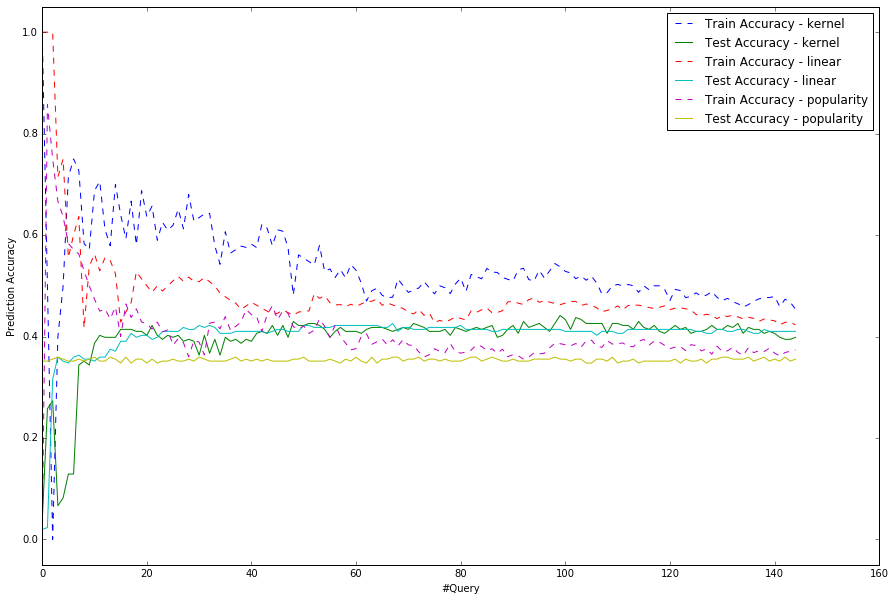

In [92]:
plt.figure(figsize=[15, 10])
plt.ylim([-0.05, 1.05])
plt.xlabel('#Query')
plt.ylabel('Prediction Accuracy')

plt.plot(np.arange(len(acc_train_k)), acc_train_k, ls='--', label='Train Accuracy - kernel')
plt.plot(np.arange(len(acc_test_k)), acc_test_k, ls='-', label='Test Accuracy - kernel')

plt.plot(np.arange(len(acc_train_l)), acc_train_l, ls='--', label='Train Accuracy - linear')
plt.plot(np.arange(len(acc_test_l)), acc_test_l, ls='-', label='Test Accuracy - linear')

plt.plot(np.arange(len(acc_train_p)), acc_train_p, ls='--', label='Train Accuracy - popularity')
plt.plot(np.arange(len(acc_test_p)), acc_test_p, ls='-', label='Test Accuracy - popularity')

plt.legend(loc='best')

In [94]:
Acc_data = (acc_train_k, acc_test_k, acc_train_l, acc_test_l, acc_train_p, acc_test_p)
pickle.dump(Acc_data, open(fAccdata, 'wb'))